In [73]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
import seaborn as sns

### OS (os)
* Fungsi: Mengakses dan berinteraksi dengan sistem file.
* Mengapa Diperlukan: Untuk membaca gambar dari folder dataset, membuat path absolut/relatif, dan menjelajah direktori berisi gambar daging.

### OpenCV (cv2)
* Fungsi: OpenCV adalah pustaka sumber terbuka untuk pengolahan citra dan video.
* Mengapa Diperlukan: Dalam proyek ini, OpenCV digunakan untuk membaca citra daging, mengubah ukuran, konversi warna (RGB ke grayscale), dan operasi pemrosesan citra seperti segmentasi, thresholding, dan deteksi tepi yang penting dalam ekstraksi fitur warna dan tekstur.


### NumPy (numpy)
* Fungsi: NumPy adalah pustaka untuk komputasi numerik dan manipulasi array multidimensi.
* Mengapa Diperlukan: Dalam proyek ini, NumPy digunakan untuk menyimpan dan mengelola data fitur dalam bentuk array, melakukan operasi matematis pada citra, dan manipulasi array yang efisien selama preprocessing dan ekstraksi fitur.


### Matplotlib (matplotlib.pyplot)
* Fungsi: Pustaka visualisasi data yang umum digunakan di Python.
* Mengapa Diperlukan: Digunakan untuk menampilkan gambar daging sebelum dan sesudah preprocessing, serta untuk memvisualisasikan hasil klasifikasi seperti confusion matrix dan grafik evaluasi lainnya.


### Pandas (pandas)
* Fungsi: Pustaka untuk manipulasi data dalam bentuk tabel (DataFrame).
* Mengapa Diperlukan: Pandas digunakan untuk menyimpan fitur warna dan tekstur bersama label kelas (Segar/Busuk), serta mempermudah analisis dan pembagian dataset untuk pelatihan dan pengujian.


### Scikit-learn (sklearn)
#### Model Selection
* `train_test_split`
  * Fungsi: Membagi dataset menjadi set pelatihan dan pengujian.
  * Mengapa Diperlukan: Untuk membagi data secara acak sehingga model dapat dilatih dan diuji secara objektif.
* `cross_val_predict`
  * Fungsi: Melakukan prediksi menggunakan validasi silang.
  * Mengapa Diperlukan: Untuk mendapatkan evaluasi performa model yang lebih stabil dan akurat dengan cross-validation.
#### Metrics
* `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `confusion_matrix`, `classification_report`, `ConfusionMatrixDisplay`
  * Fungsi: Menghitung metrik evaluasi untuk model klasifikasi.
  * Mengapa Diperlukan: Digunakan untuk mengevaluasi performa model berdasarkan akurasi, presisi, recall, F1-score, dan matriks kebingungan, yang penting untuk membandingkan keefektifan model dalam mengenali daging segar dan busuk.
#### Classifiers
* `RandomForestClassifier`
  * Fungsi: Algoritma ensemble berbasis pohon keputusan.
  * Mengapa Diperlukan: Cocok untuk klasifikasi dengan fitur yang bervariasi (warna dan tekstur), memberikan hasil yang stabil dan akurat.
* `SVC` (Support Vector Classifier)
  * Fungsi: Algoritma klasifikasi yang memisahkan kelas menggunakan hyperplane.
  * Mengapa Diperlukan: Sangat efektif untuk klasifikasi data dengan margin yang jelas.
* `KNeighborsClassifier`
  * Fungsi: Klasifikasi berdasarkan kedekatan (jarak) ke tetangga terdekat.
  * Mengapa Diperlukan: Memberikan hasil klasifikasi sederhana berdasarkan pola sebaran fitur pada ruang vektor.

### Skimage (skimage.feature)
#### `graycomatrix`, `graycoprops`
* Fungsi: Ekstraksi fitur tekstur menggunakan **Gray-Level Co-Occurrence Matrix (GLCM)**.
* Mengapa Diperlukan: GLCM digunakan untuk mendapatkan informasi tekstur dari citra grayscale seperti kontras, homogenitas, ASM, dan korelasi, yang penting untuk membedakan antara daging segar dan busuk.


### Scipy (scipy.stats.entropy)
* Fungsi: Menghitung entropi dari distribusi piksel.
* Mengapa Diperlukan: Entropi digunakan sebagai salah satu fitur tekstur yang mengukur tingkat ketidakteraturan atau keragaman tekstur dalam citra daging.


### Seaborn (seaborn)
* Fungsi: Visualisasi data statistik yang lebih menarik.
* Mengapa Diperlukan: Digunakan untuk menampilkan confusion matrix dengan visual yang lebih informatif dan estetis dibanding Matplotlib standar.

## Data Loading

In [74]:
data = []
file_name = []
datalabel = []
path = []
data_distribution = {}

for label in os.listdir("dataset"):
    label_path = os.path.join("dataset", label)
    if not os.path.isdir(label_path):
        continue
    images = os.listdir(label_path)
    data_distribution[label] = len(images)
    print(f"Memproses label: {label}, jumlah gambar: {len(images)}")

    for filename in images:
        img_path = os.path.join(label_path, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            data.append(img)
            datalabel.append(label)  
            file_name.append(filename)
            path.append(img_path)

print("Data: ", len(data))
print("Label: ", len(datalabel))
print("Filenames: ", len(file_name))
print("Data Distribution: ", data_distribution)

Memproses label: fresh, jumlah gambar: 72
Memproses label: spoiled, jumlah gambar: 72
Data:  144
Label:  144
Filenames:  144
Data Distribution:  {'fresh': 72, 'spoiled': 72}


Kode diatas digunakan untuk memuat dan menganalisis data citra daging yang disimpan dalam direktori dataset, sebagai tahap awal dalam proses klasifikasi kualitas daging. Setiap folder di dalam direktori `dataset` dianggap sebagai satu kelas atau label, misalnya "Segar" dan "Busuk". Program akan menjelajahi setiap folder, membaca semua gambar di dalamnya, dan mencatat jumlah gambar per label untuk memantau distribusi data. Proses ini dilakukan menggunakan pustaka `os` untuk navigasi folder dan `cv2` (OpenCV) untuk membaca gambar.        
Setiap gambar dibaca menggunakan `cv2.imread`, kemudian dikonversi dari format warna BGR (default OpenCV) ke RGB agar sesuai dengan format tampilan dan pengolahan umum di Python.  Gambar-gambar yang berhasil dibaca kemudian disimpan dalam list `data`, sementara nama file, label, dan path aslinya masing-masing disimpan dalam list `file_name`, `datalabel`, dan `path`. Informasi distribusi jumlah gambar per label juga disimpan dalam dictionary `data_distribution` untuk membantu memahami apakah dataset seimbang.   
Output dari proses ini mencakup jumlah total gambar yang berhasil dimuat, jumlah label, dan distribusi data per kategori. Ini sangat penting untuk memastikan bahwa data telah dimuat dengan benar dan proporsional sebelum dilakukan tahap preprocessing, ekstraksi fitur, dan pelatihan model klasifikasi. Dengan demikian, kode ini memainkan peran krusial dalam menyiapkan dataset citra daging secara sistematis dan terstruktur sebelum proses pembelajaran mesin dilakukan.

Kode di bawah digunakan untuk menampilkan sejumlah gambar dari dataset dalam bentuk grid visual menggunakan matplotlib. Fungsi `displayImg(row, column, data)` menerima tiga parameter yaitu jumlah baris (`row`), jumlah kolom (`column`), dan data gambar (`data`) yang akan ditampilkan. Dengan membuat figure berukuran 15x10 inci, fungsi ini secara otomatis membagi tampilan gambar ke dalam beberapa subplot menggunakan perulangan, di mana setiap subplot diisi dengan gambar dari dataset yang ditentukan. Gambar ditampilkan menggunakan `plt.imshow()` dengan opsi skala abu-abu (`cmap='gray'`), dan sumbu koordinat disembunyikan agar tampilan lebih bersih. Fungsi ini sangat berguna untuk melakukan inspeksi visual awal terhadap data citra seperti memverifikasi apakah gambar telah ter-load dengan benar, memeriksa kualitas citra, dan menilai variasi antar kelas (misalnya daging segar dan busuk) sebelum proses pelatihan model dimulai.


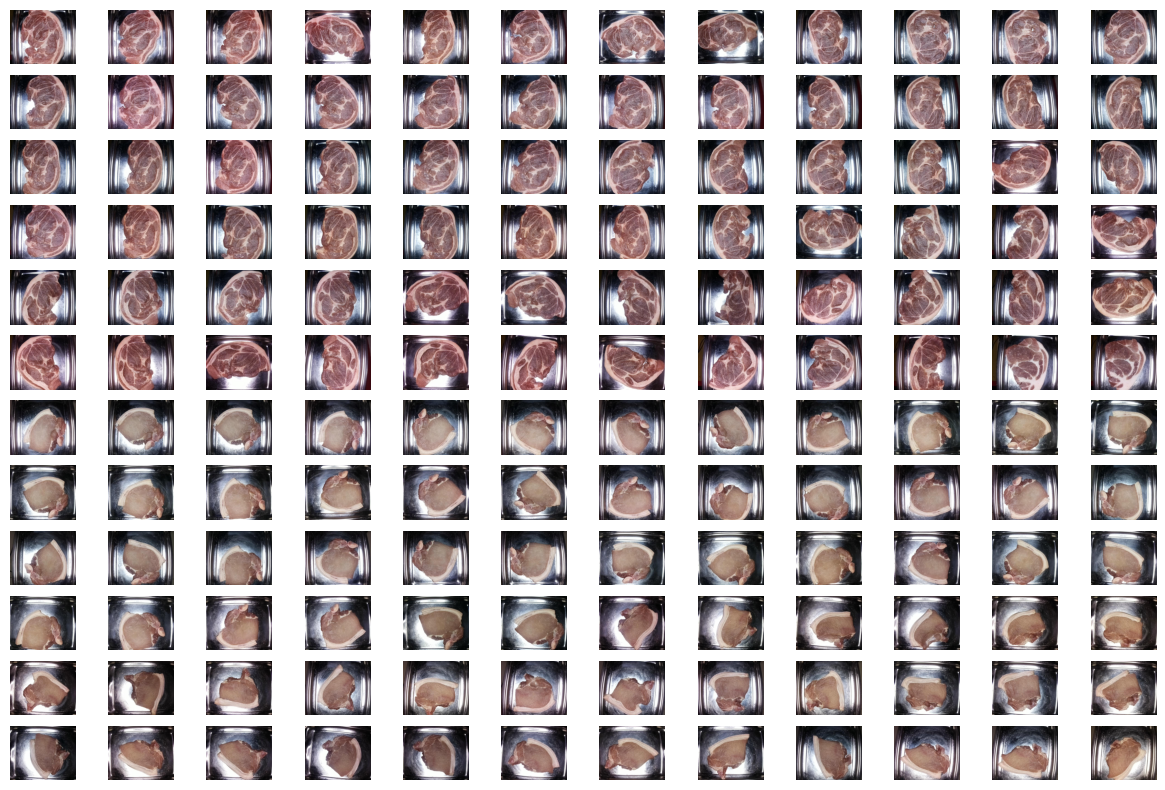

In [75]:
def displayImg(row, column, data):
    fig = plt.figure(figsize=(15, 10))
    for i in range(1, row * column + 1):
        fig.add_subplot(row, column, i)
        plt.imshow(data[i - 1], cmap='gray')
        plt.axis('off')  
    plt.show()
displayImg(12,12, data)

## Data Augmentation

### Define Augmentation Function


In [ ]:
# data_augmented = [] 
# labels_augmented = []
# file_name_augmented = []

# def flip_horizontal(image):
#     return np.fliplr(image)

# def rotate(image):
#     return np.rot90(image, k=3)  

# for i in range(len(data)):
#     original = data[i]
#     flipped = flip_horizontal(original)
#     rotated = rotate(original)

#     data_augmented.extend([flipped, rotated])
#     labels_augmented.extend([datalabel[i]] * 2)
#     file_name_augmented.extend([file_name[i] + '_flip', file_name[i] + '_rot'])

# print("Jumlah data sebelum augmentasi:", len(data))
# print("Jumlah data setelah augmentasi:", len(data_augmented))


Jumlah data sebelum augmentasi: 144
Jumlah data setelah augmentasi: 288


Kode di atas digunakan untuk melakukan augmentasi data gambar guna memperbanyak variasi dan jumlah data pelatihan tanpa perlu menambah gambar baru secara manual. Dalam proses ini, dua teknik augmentasi diterapkan, yaitu *horizontal flip* dan *rotasi*. Pertama, tiga list kosong (`data_augmented`, `labels_augmented`, dan `file_name_augmented`) disiapkan untuk menyimpan gambar yang telah diaugmentasi, labelnya, serta nama file barunya. Fungsi `flip_horizontal(image)` digunakan untuk membalik gambar secara horizontal, sedangkan `rotate(image)` memutar gambar sebesar 270 derajat (rotasi 90 derajat sebanyak 3 kali searah jarum jam).     
Selanjutnya, melalui iterasi terhadap setiap gambar dalam dataset asli (`data`), gambar asli diproses menggunakan kedua fungsi augmentasi tersebut. Gambar hasil *flip* dan rotasi kemudian ditambahkan ke dalam list `data_augmented`, sementara label yang sama dengan gambar aslinya ditambahkan ke `labels_augmented`, dan nama file baru yang mencerminkan proses augmentasinya juga disimpan di `file_name_augmented`. Di akhir proses, jumlah data sebelum dan sesudah augmentasi dicetak untuk menunjukkan peningkatan jumlah data. Augmentasi ini penting dalam proyek klasifikasi seperti deteksi kualitas daging, karena membantu meningkatkan generalisasi model dengan memberikan variasi data yang lebih luas.


## Data Preparation

### Define Preprocessing Function


In [77]:
def resize(image, new_width, new_height):
    old_height, old_width = image.shape[:2]
    channels = 1 if len(image.shape) == 2 else image.shape[2]

    if channels == 1:
        resized_image = np.zeros((new_height, new_width), dtype=image.dtype)
    else:
        resized_image = np.zeros((new_height, new_width, channels), dtype=image.dtype)

    for i in range(new_height):
        for j in range(new_width):
            x = int(j * old_width / new_width)
            y = int(i * old_height / new_height)
            resized_image[i, j] = image[y, x]

    return resized_image

Kode di atas merupakan fungsi `resize()` yang digunakan untuk mengubah ukuran (resolusi) gambar secara manual tanpa menggunakan pustaka eksternal seperti OpenCV. Fungsi ini menerima gambar (`image`) serta ukuran baru yang diinginkan yaitu `new_width` dan `new_height`. Pertama, fungsi menghitung ukuran asli gambar dan mendeteksi jumlah channel (1 untuk grayscale dan 3 untuk RGB). Selanjutnya, fungsi membuat array kosong sebagai tempat gambar hasil resize dengan ukuran baru. Proses resizing dilakukan dengan cara memetakan setiap piksel pada gambar baru ke posisi piksel yang sesuai pada gambar lama menggunakan perbandingan skala lebar dan tinggi. Piksel pada posisi `(i, j)` di gambar baru diisi dengan nilai dari posisi `(y, x)` yang sesuai di gambar lama. Fungsi ini cocok digunakan untuk pemrosesan dasar dan tidak melibatkan interpolasi kompleks seperti bilinear atau bicubic.

In [78]:
def grayscale(img):
    B = img[:, :, 0]
    G = img[:, :, 1]
    R = img[:, :, 2]
    gray_img = (0.299 * R + 0.587 * G + 0.114 * B).astype(np.uint8)
    return gray_img

Kode di atas mendefinisikan fungsi `grayscale` yang melakukan konversi citra berwarna (RGB) menjadi citra grayscale secara manual dengan menggunakan rumus luminansi standar. Fungsi ini mengekstrak masing-masing kanal warna biru (`b`), hijau (`g`), dan merah (`r`) dari citra input `img`, lalu menghitung nilai intensitas grayscale berdasarkan kontribusi masing-masing kanal: 0.114 untuk biru, 0.587 untuk hijau, dan 0.299 untuk merah. Hasil konversi tersebut kemudian dikembalikan dalam bentuk array bertipe `uint8` yang mewakili citra grayscale.


In [79]:
def equalization(image):
    frequent = {}
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            value = image[i, j]
            if value in frequent:
                frequent[value] += 1
            else:
                frequent[value] = 1

    cumuFreq = {}
    sortedKey = sorted(frequent.keys())
    
    total = 0
    for key in sortedKey:
        total += frequent[key]
        cumuFreq[key] = total

    newPixel = {}
    sumAllPixel = image.shape[0] * image.shape[1]
    for key in sortedKey:
        newPixel[key] = round((cumuFreq[key] / sumAllPixel) * 255)

    newImage = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            newImage[i, j] = newPixel[image[i, j]]

    return newImage
    

Kode di atas merupakan fungsi bernama `equalization` yang digunakan untuk melakukan ekualisasi histogram pada gambar grayscale. Proses ini bertujuan untuk meningkatkan kontras gambar dengan menyebarkan intensitas piksel secara lebih merata. Pertama, fungsi ini menghitung frekuensi kemunculan setiap nilai intensitas piksel. Selanjutnya, frekuensi tersebut diubah menjadi fungsi distribusi kumulatif (CDF). Berdasarkan CDF, setiap nilai intensitas asli dipetakan ke nilai intensitas baru menggunakan rumus `round((cumuFreq[key] / sumAllPixel) * 255)`. Nilai baru ini kemudian digunakan untuk membentuk gambar hasil ekualisasi, di mana setiap piksel asli diganti dengan piksel hasil transformasi tersebut. Hasil akhirnya adalah gambar dengan kontras yang lebih baik.

Kode di bawah digunakan untuk melakukan *preprocessing* sederhana terhadap 10 gambar buah segar (`fresh`) dan 10 gambar buah busuk (`spoiled`) dari dataset. Setiap gambar terlebih dahulu diubah ukurannya menjadi 350x350 piksel menggunakan fungsi `resize`, kemudian dikonversi menjadi citra grayscale dengan fungsi `grayscale`, dan dilakukan peningkatan kontras menggunakan ekualisasi histogram (`equalization`). Hasil preprocessing ini kemudian disimpan dalam dua list terpisah, yaitu `fresh_images` untuk gambar buah segar dan `spoiled_images` untuk gambar buah busuk. Setelah 10 gambar dari masing-masing kategori berhasil diproses, hasilnya ditampilkan dalam bentuk grid 2 baris dan 5 kolom menggunakan fungsi `displayImg`.


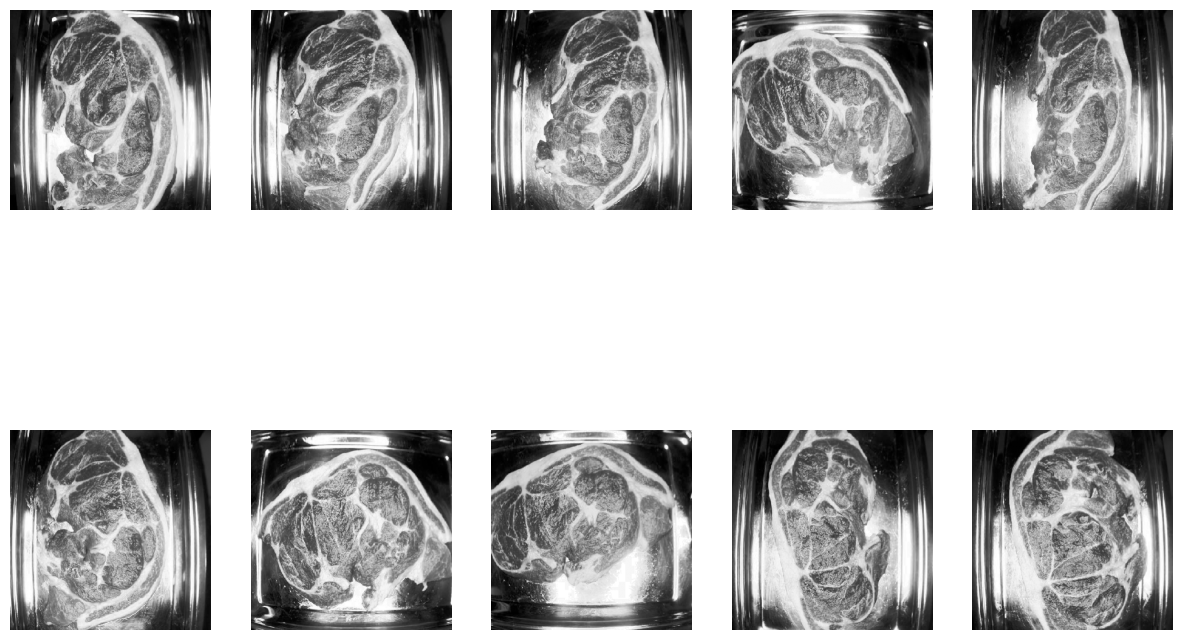

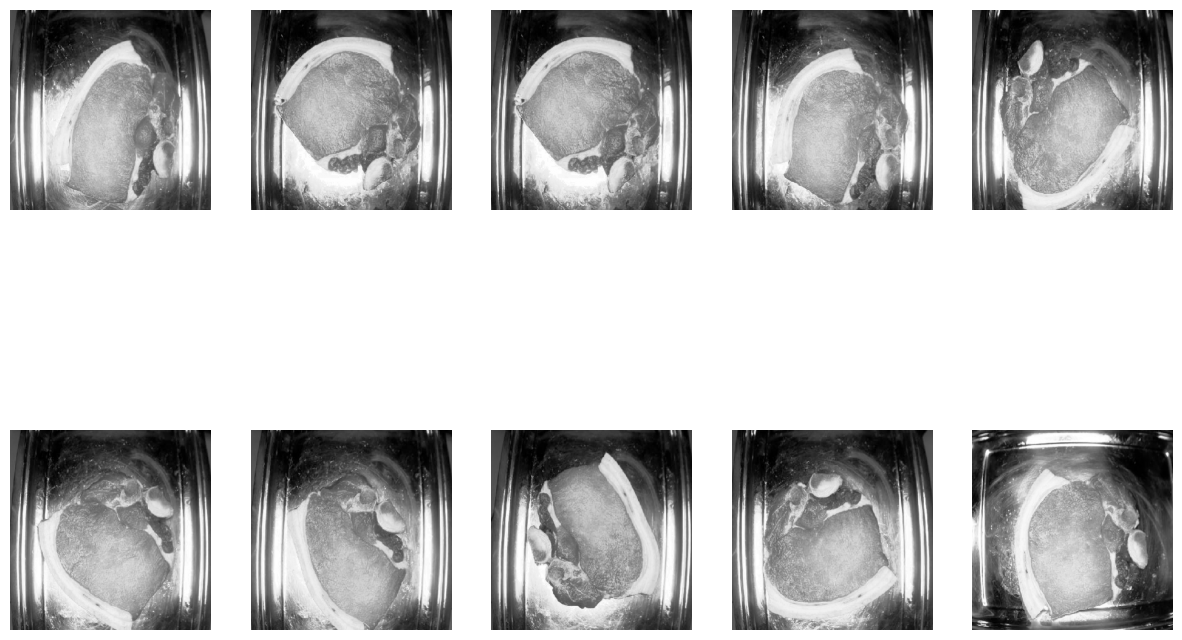

In [80]:
fresh_images = []
spoiled_images = []

for i in range(len(data)):
    if datalabel[i].lower() == 'fresh' and len(fresh_images) < 10:
        resize_img= resize(data[i], 350, 350)                  
        gray = grayscale(resize_img)
        ekual = equalization(gray)
        fresh_images.append(ekual)
        
    elif datalabel[i].lower() == 'spoiled' and len(spoiled_images) < 10:
        resize_img = resize(data[i], 350, 350)                  
        gray = grayscale(resize_img)
        ekual = equalization(gray)
        spoiled_images.append(ekual)

    if len(fresh_images) >= 10 and len(spoiled_images) >= 10:
        break

displayImg(2, 5, fresh_images)
displayImg(2, 5, spoiled_images)


### Preprocessing

In [81]:
dataPreprocessed = []
for i in range(len(data)):
    img = resize(data[i], 128, 128)                  
    img = grayscale(img)         
    img = equalization(img)                                         
    dataPreprocessed.append(img)

Kode di atas digunakan untuk melakukan preprocessing secara menyeluruh pada seluruh dataset gambar. Setiap gambar dalam list `data` terlebih dahulu diubah ukurannya menjadi 128x128 piksel menggunakan `resize` agar seragam. Setelah itu, gambar dikonversi ke grayscale menggunakan fungsi `grayscale`, dilanjutkan dengan ekualisasi histogram melalui fungsi `equalization` untuk meningkatkan kontras. Kemudian dilakukan deteksi tepi menggunakan operator Sobel (`sobel`), hasilnya dihaluskan dengan Gaussian Blur (`gaussian_blur`) menggunakan kernel berukuran 5x5 untuk mengurangi noise, dan terakhir dilakukan thresholding dengan nilai ambang 128 agar gambar menjadi biner. Semua gambar hasil preprocessing tersebut disimpan dalam list baru bernama `dataPreprocessed` yang siap digunakan untuk proses pelatihan atau klasifikasi.


### Feature Extraction

In [82]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Kode di atas merupakan sebuah fungsi bernama `glcm` yang digunakan untuk menghitung matriks GLCM (Gray Level Co-occurrence Matrix) dari sebuah citra grayscale. Fungsi ini menerima dua parameter: `image` (gambar grayscale) dan `derajat` (sudut arah dalam derajat). Berdasarkan nilai `derajat` yang diberikan (0, 45, 90, atau 135), kode ini mengonversi nilai derajat tersebut menjadi sudut dalam radian yang sesuai dengan format yang digunakan oleh fungsi `graycomatrix` dari pustaka `skimage.feature`. Fungsi `graycomatrix` kemudian digunakan untuk menghasilkan matriks GLCM dengan jarak antar piksel sebesar 1, simetris, dan ternormalisasi. Hasilnya berupa array GLCM yang menggambarkan hubungan spasial antara tingkat keabuan dalam gambar, yang berguna sebagai fitur tekstur dalam pengolahan citra atau klasifikasi.


In [83]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Kode di atas merupakan sebuah fungsi bernama `correlation` yang digunakan untuk menghitung nilai korelasi dari matriks GLCM (Gray Level Co-occurrence Matrix) yang telah dihasilkan sebelumnya. Fungsi ini memanfaatkan `graycoprops` dari pustaka `skimage.feature` dengan parameter `'correlation'` untuk mengambil nilai properti korelasi, yaitu ukuran statistik yang menunjukkan sejauh mana tingkat keabuan suatu piksel berkorelasi dengan piksel tetangganya di seluruh gambar. Nilai hasilnya diakses pada indeks `[0, 0]` karena output dari `graycoprops` berbentuk array dua dimensi. Hasil korelasi ini sering digunakan sebagai fitur dalam analisis tekstur atau klasifikasi citra.


In [84]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Kode di atas merupakan fungsi bernama `dissimilarity` yang digunakan untuk menghitung nilai dissimilarity (ketidaksamaan) dari matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan `graycoprops` dari pustaka `skimage.feature` dengan parameter `'dissimilarity'` untuk memperoleh ukuran seberapa besar perbedaan nilai keabuan antara piksel-piksel yang berdekatan dalam gambar. Nilai tersebut kemudian diambil pada indeks `[0, 0]`, karena hasil `graycoprops` berbentuk array 2 dimensi. Dissimilarity ini biasanya digunakan sebagai salah satu fitur dalam ekstraksi ciri tekstur untuk keperluan klasifikasi atau analisis citra.


In [85]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Kode di atas merupakan fungsi bernama `homogenity` yang digunakan untuk menghitung nilai homogenitas dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini memanfaatkan `graycoprops` dari pustaka `skimage.feature` dengan parameter `'homogeneity'` untuk mengukur seberapa seragam atau mirip nilai intensitas antar piksel yang berdekatan dalam sebuah citra. Nilai homogenitas diambil dari indeks `[0, 0]` karena hasilnya berbentuk array 2 dimensi. Nilai ini biasanya digunakan sebagai fitur tekstur dalam pengolahan citra, seperti klasifikasi atau segmentasi.


In [86]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Kode di atas merupakan fungsi bernama `contrast` yang digunakan untuk menghitung nilai kontras dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan `graycoprops` dari pustaka `skimage.feature` dengan parameter `'contrast'`, yang mengukur perbedaan intensitas antara piksel bersebelahan dalam citra. Nilai kontras diambil dari posisi `[0, 0]` karena hasil `graycoprops` berbentuk array 2 dimensi. Nilai kontras ini berguna sebagai salah satu fitur tekstur dalam analisis citra, misalnya untuk klasifikasi kondisi permukaan objek.


In [87]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Kode di atas merupakan fungsi bernama `ASM` yang digunakan untuk menghitung nilai Angular Second Moment dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini memanfaatkan `graycoprops` dari pustaka `skimage.feature` dengan parameter `'ASM'`, yang menunjukkan tingkat keseragaman atau kekompakan pola tekstur dalam citra. Nilai ASM diperoleh dari indeks `[0, 0]` karena `graycoprops` menghasilkan array dua dimensi. Semakin tinggi nilai ASM, semakin seragam tekstur dalam gambar tersebut. Fitur ini sering digunakan dalam analisis tekstur untuk klasifikasi citra.


In [88]:
def energy(matrix):
    return graycoprops(matrix, 'energy')[0, 0]

Kode di atas merupakan fungsi bernama `energy` yang digunakan untuk menghitung nilai Energy dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan metode `graycoprops` dari pustaka `skimage.feature` dengan parameter `'energy'`, yang merepresentasikan akar kuadrat dari nilai Angular Second Moment (ASM). Nilai ini mencerminkan tingkat keseragaman atau keteraturan tekstur pada gambar—semakin tinggi nilai energy, semakin seragam teksturnya. Hasilnya diambil dari indeks `[0, 0]` karena output `graycoprops` berbentuk array dua dimensi. Nilai energy ini umum digunakan sebagai salah satu fitur dalam analisis tekstur citra untuk keperluan klasifikasi atau segmentasi.


In [89]:
def entropyGlcm(matrix):
    glcm_array = matrix[:, :, 0, 0]
    return entropy(glcm_array.flatten())

Kode di atas merupakan fungsi bernama `entropyGlcm` yang digunakan untuk menghitung nilai **entropi** dari matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini terlebih dahulu mengambil array 2 dimensi dari matriks GLCM dengan indeks `[:, :, 0, 0]`, kemudian meratakannya menjadi satu dimensi menggunakan `flatten()`. Nilai entropi dihitung dengan fungsi `entropy()` dari pustaka `scipy.stats`, yang mengukur ketidakteraturan atau kompleksitas tekstur dalam gambar. Semakin tinggi nilai entropi, semakin acak atau kompleks pola tekstur pada gambar tersebut. Fitur ini sering digunakan dalam ekstraksi ciri tekstur untuk klasifikasi atau pengenalan pola citra.


In [90]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode di atas digunakan untuk menghitung matriks GLCM (Gray Level Co-occurrence Matrix) dari setiap citra yang telah dipreproses pada empat sudut arah berbeda, yaitu 0°, 45°, 90°, dan 135°. Untuk setiap gambar dalam daftar `dataPreprocessed`, fungsi `glcm()` dipanggil dengan parameter sudut tertentu, kemudian hasil GLCM-nya disimpan ke dalam daftar yang sesuai: `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Langkah ini penting dalam ekstraksi ciri tekstur karena arah hubungan antar piksel dalam sebuah citra dapat memengaruhi informasi tekstur yang dihasilkan, sehingga perhitungan GLCM pada berbagai arah dapat membantu menghasilkan fitur yang lebih representatif untuk analisis atau klasifikasi.


In [91]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Kode di atas mendeklarasikan sejumlah daftar kosong (list) yang masing-masing digunakan untuk menyimpan nilai fitur tekstur dari citra berdasarkan arah sudut dalam perhitungan *Gray Level Co-occurrence Matrix* (GLCM), yaitu 0°, 45°, 90°, dan 135°. Fitur-fitur yang dimaksud mencakup kontras, dissimilarity, homogenitas, entropi, ASM (Angular Second Moment), energi, dan korelasi, yang semuanya merupakan metrik umum dalam analisis tekstur citra. Setiap fitur memiliki empat daftar yang terpisah sesuai arah sudutnya, dengan tujuan agar nilai-nilai dari masing-masing arah bisa dianalisis secara individual maupun dibandingkan untuk mendapatkan informasi tekstur yang lebih lengkap dan akurat dari suatu citra.


In [92]:
for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode di atas merupakan bagian dari proses ekstraksi fitur korelasi dari citra yang telah dipra-proses, dengan menggunakan matriks GLCM pada empat arah sudut yaitu 0°, 45°, 90°, dan 135°. Dalam setiap iterasi dari perulangan for, fungsi correlation() digunakan untuk menghitung nilai korelasi dari matriks GLCM yang disimpan dalam variabel Derajat0, Derajat45, Derajat90, dan Derajat135 pada indeks ke-i, yang merepresentasikan citra ke-i dari dataset dataPreprocessed. Hasil korelasi dari masing-masing arah kemudian disimpan ke dalam list correlation0, correlation45, correlation90, dan correlation135, sesuai dengan arah sudutnya masing-masing, untuk digunakan dalam proses analisis atau klasifikasi lebih lanjut.

In [93]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode di atas digunakan untuk menghitung dan menyimpan nilai fitur kontras dari matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah sudut, yaitu 0°, 45°, 90°, dan 135°, untuk setiap citra dalam dataset data. Dalam setiap iterasi, fungsi contrast() menghitung nilai kontras dari matriks GLCM yang disimpan dalam Derajat0[i], Derajat45[i], Derajat90[i], dan Derajat135[i]—yang masing-masing mewakili sudut arah dari tekstur citra ke-i. Hasil perhitungan dari setiap arah kemudian disimpan ke dalam list Kontras0, Kontras45, Kontras90, dan Kontras135, yang nantinya dapat digunakan sebagai fitur dalam analisis lebih lanjut seperti klasifikasi atau pengenalan pola.

In [94]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode di atas digunakan untuk menghitung nilai fitur dissimilarity dari matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah sudut—yaitu 0°, 45°, 90°, dan 135°—untuk setiap citra dalam dataset data. Pada setiap iterasi, fungsi dissimilarity() menghitung tingkat perbedaan nilai keabuan antar piksel dari matriks GLCM pada arah tertentu untuk citra ke-i. Hasil perhitungan dari masing-masing arah disimpan ke dalam list dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135. Nilai-nilai ini nantinya dapat digunakan sebagai fitur deskriptif dalam proses analisis tekstur, seperti klasifikasi citra atau pengenalan objek berbasis pola tekstur.

In [95]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode di atas berfungsi untuk menghitung dan menyimpan nilai fitur homogenitas dari matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah sudut, yaitu 0°, 45°, 90°, dan 135°, untuk setiap citra dalam dataset data. Dalam setiap iterasi, fungsi homogenity() digunakan untuk mengukur seberapa seragam atau konsisten nilai keabuan antar piksel pada matriks GLCM dari citra ke-i pada arah tertentu. Nilai homogenitas yang dihasilkan dari masing-masing sudut disimpan dalam list homogenity0, homogenity45, homogenity90, dan homogenity135. Fitur homogenitas ini penting dalam analisis tekstur karena menunjukkan tingkat keseragaman pada suatu wilayah citra.

In [96]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode di atas digunakan untuk menghitung dan menyimpan nilai fitur entropi dari matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah sudut, yaitu 0°, 45°, 90°, dan 135°, untuk setiap citra dalam dataset data. Dalam setiap iterasi, fungsi entropyGlcm() digunakan untuk menghitung entropi dari matriks GLCM pada arah tertentu untuk citra ke-i. Entropi mencerminkan tingkat ketidakteraturan atau kompleksitas tekstur dalam citra—semakin tinggi nilai entropi, semakin acak pola teksturnya. Nilai hasil perhitungan dari tiap arah kemudian disimpan ke dalam list entropy0, entropy45, entropy90, dan entropy135, yang bisa dimanfaatkan sebagai fitur dalam analisis citra berbasis tekstur.

In [97]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode di atas digunakan untuk menghitung dan menyimpan nilai fitur ASM (Angular Second Moment) dari matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah sudut, yaitu 0°, 45°, 90°, dan 135°, untuk setiap citra dalam dataset data. Dalam setiap iterasi, fungsi ASM() digunakan untuk menghitung nilai kekompakan atau keteraturan tekstur dari matriks GLCM pada arah tertentu untuk citra ke-i. ASM yang tinggi menunjukkan tekstur yang lebih seragam atau terstruktur. Nilai ASM dari masing-masing sudut kemudian disimpan ke dalam list ASM0, ASM45, ASM90, dan ASM135, yang nantinya digunakan sebagai fitur dalam analisis atau klasifikasi tekstur citra.

In [98]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode di atas digunakan untuk menghitung dan menyimpan nilai fitur energi dari matriks GLCM (Gray Level Co-occurrence Matrix) pada empat arah sudut—yaitu 0°, 45°, 90°, dan 135°—untuk setiap citra dalam dataset data. Pada setiap iterasi, fungsi energy() digunakan untuk menghitung energi dari GLCM pada arah tertentu untuk citra ke-i. Fitur energi menggambarkan tingkat keteraturan atau kekompakan tekstur, dan nilainya merupakan akar kuadrat dari nilai ASM (Angular Second Moment), sehingga semakin tinggi nilai energi, semakin teratur teksturnya. Nilai hasil perhitungan kemudian disimpan ke dalam list energy0, energy45, energy90, dan energy135, yang dapat digunakan dalam proses analisis tekstur atau klasifikasi citra.

### Write the extraction's results to CSV 

Kode di bawah berfungsi untuk membuat sebuah DataFrame dari beberapa variabel fitur tekstur citra yang telah diekstraksi, kemudian menyimpannya dalam format file CSV dengan nama `hasil_ekstraksi_1.csv`. Variabel-variabel tersebut meliputi nama file gambar (`Filename`), label kelas (`Label`), dan beberapa fitur tekstur seperti Kontras, Homogenitas, Disimilari, Entropi, ASM, Energi, dan Korelasi yang dihitung pada berbagai sudut orientasi (0°, 45°, 90°, dan 135°). Setelah DataFrame terbentuk, kode tersebut menyimpan data ke file CSV tanpa menyertakan indeks, lalu membacanya kembali ke dalam variabel `hasilEkstrak` untuk ditampilkan atau digunakan dalam proses selanjutnya.


In [99]:
dataTable = {'Filename': file_name, 'Label': datalabel,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,08-11-2022-09-29-23_jpg.rf.64d249dc62a73d0ad8a...,fresh,1560.352793,1872.937690,815.162279,1778.853060,0.086718,0.078650,0.159482,0.079380,...,0.000391,0.000168,0.013511,0.012970,0.019762,0.012944,0.854727,0.824914,0.924393,0.833719
1,08-11-2022-09-31-38_jpg.rf.a062a431d30171b3151...,fresh,1810.618971,2123.815364,830.179626,1978.028396,0.080469,0.068844,0.136580,0.072685,...,0.000234,0.000120,0.011183,0.010646,0.015285,0.010947,0.832257,0.802530,0.923025,0.816078
2,08-11-2022-09-33-12_jpg.rf.b59993e6f78e188270c...,fresh,1787.837168,2078.798810,770.894254,1902.546531,0.080441,0.069063,0.139015,0.074579,...,0.000247,0.000122,0.011244,0.010737,0.015725,0.011028,0.834640,0.807466,0.928688,0.823788
3,08-11-2022-09-33-46_jpg.rf.ac147752030f7341361...,fresh,1102.929503,1507.720751,1076.363681,1663.031248,0.122611,0.092397,0.116753,0.086282,...,0.000392,0.000302,0.020156,0.017427,0.019796,0.017384,0.897784,0.859719,0.900339,0.845267
4,08-11-2022-09-38-25_jpg.rf.98422f41a439f4b9caf...,fresh,1489.765010,1646.601959,501.426673,1514.974766,0.086084,0.080473,0.152240,0.083072,...,0.000313,0.000160,0.012776,0.012333,0.017693,0.012631,0.862373,0.847555,0.953574,0.859738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,08-11-2022-22-04-53_jpg.rf.898d4dacb6b481c54a1...,spoiled,781.585384,1230.209188,797.491941,1167.815674,0.135822,0.097434,0.131942,0.103926,...,0.000475,0.000375,0.022348,0.018766,0.021800,0.019369,0.927431,0.885725,0.926364,0.891521
140,08-11-2022-22-05-41_jpg.rf.1911a77bc56f9cf0c0d...,spoiled,1300.310101,1380.095294,293.099102,1359.727447,0.108302,0.099622,0.169547,0.091429,...,0.000491,0.000243,0.016363,0.016011,0.022164,0.015575,0.879711,0.872105,0.972806,0.874001
141,08-11-2022-22-06-09_jpg.rf.22c8c2df12f95b3ce32...,spoiled,1424.384843,1606.157852,459.366818,1529.868374,0.096063,0.089687,0.147279,0.083582,...,0.000277,0.000150,0.012842,0.012352,0.016657,0.012257,0.868450,0.851186,0.957401,0.858265
142,08-11-2022-22-06-15_jpg.rf.a281f03d8553c96d251...,spoiled,1513.690453,1722.265051,508.021407,1618.810094,0.102265,0.091546,0.139184,0.083662,...,0.000327,0.000177,0.013819,0.013156,0.018074,0.013289,0.860190,0.840398,0.952887,0.849997


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

Kode di bawah pertama-tama menghitung matriks korelasi antar fitur numerik dalam dataset `hasilEkstrak`, dengan mengabaikan kolom `Label` dan `Filename`. Selanjutnya, kode melakukan penyaringan fitur dengan menghilangkan fitur-fitur yang memiliki korelasi absolut lebih besar atau sama dengan 0.95 satu sama lain untuk mengurangi redundansi, menggunakan threshold korelasi 0.95 sebagai batas pemilihan. Fitur-fitur yang terpilih kemudian disimpan dalam variabel `x_new`, sedangkan label kelas disimpan di `y`. Terakhir, kode ini membuat visualisasi heatmap dari matriks korelasi fitur yang telah disaring menggunakan seaborn untuk mempermudah analisis hubungan antar fitur yang tersisa.


<Axes: >

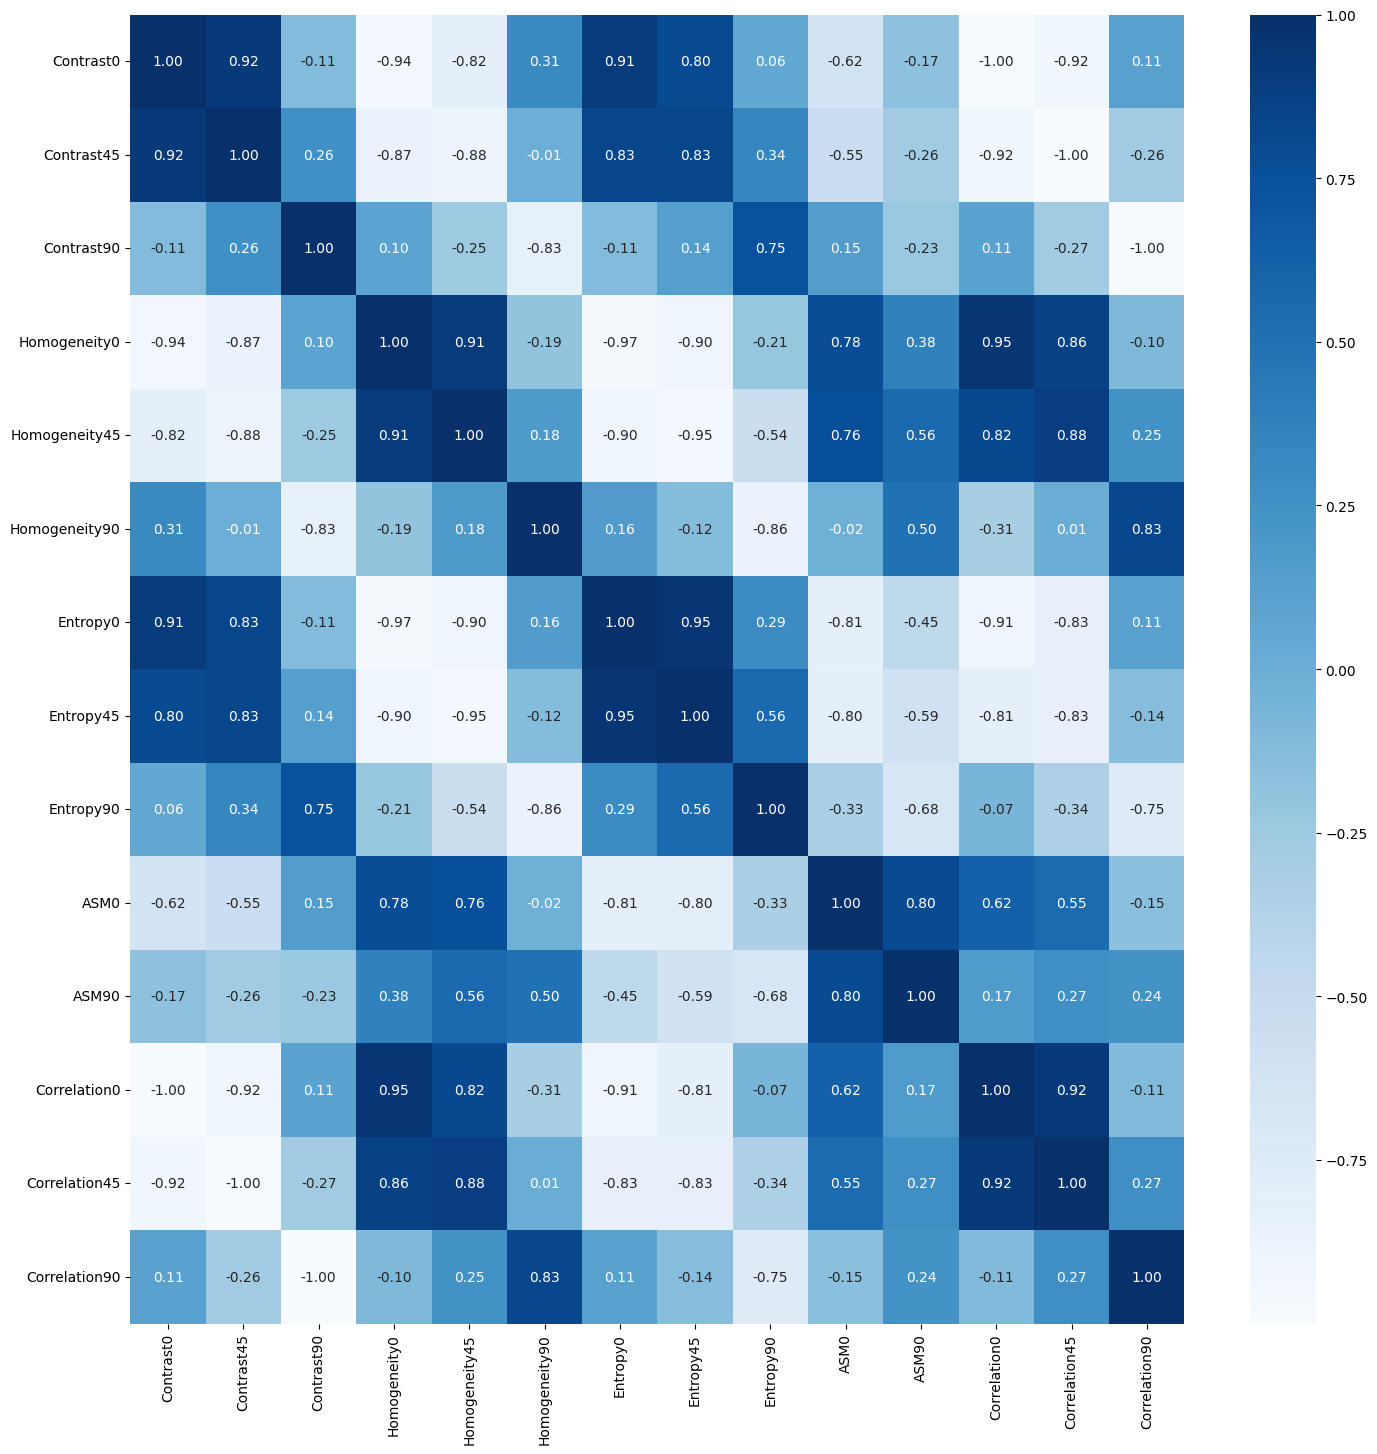

In [100]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [101]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(115, 14)
(29, 14)


Kode di atas membagi dataset fitur `x_new` dan label `y` menjadi dua bagian, yaitu data latih (`X_train`, `y_train`) dan data uji (`X_test`, `y_test`), dengan proporsi 80% untuk pelatihan dan 20% untuk pengujian berdasarkan parameter `test_size=0.2`. Parameter `random_state=42` digunakan untuk memastikan pembagian data yang konsisten jika kode dijalankan ulang. Setelah pembagian, kode mencetak ukuran (jumlah baris dan kolom) dari data latih dan data uji untuk memastikan proporsi pembagian sudah sesuai.


## Feature Normalization

In [102]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode di atas melakukan normalisasi fitur pada data latih (`X_train`) dan data uji (`X_test`) menggunakan metode standarisasi dengan mean dan standar deviasi yang dihitung dari data latih. Proses ini menggeser dan menskalakan setiap fitur sehingga memiliki rata-rata nol dan deviasi standar satu, yang bertujuan agar model pembelajaran mesin dapat bekerja lebih optimal dan menghindari bias dari skala fitur yang berbeda. Normalisasi data uji menggunakan parameter mean dan standar deviasi dari data latih agar konsistensi dalam skala data tetap terjaga.


## Modeling

### Define Model

In [103]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode di atas mendefinisikan sebuah fungsi bernama `generateClassificationReport` yang menerima dua parameter, yaitu `y_true` (label sebenarnya) dan `y_pred` (label hasil prediksi), kemudian mencetak laporan klasifikasi lengkap, matriks kebingungan, dan akurasi model menggunakan metrik dari scikit-learn. Selain itu, kode juga menginisialisasi tiga model klasifikasi yang berbeda: Random Forest dengan 5 pohon keputusan, Support Vector Machine (SVM) dengan kernel radial basis function (RBF), dan K-Nearest Neighbors (KNN) dengan jumlah tetangga sebanyak 5, yang nantinya dapat digunakan untuk pelatihan dan pengujian data klasifikasi.


### Train Random Forest Classifier

Kode di bawah melatih model Random Forest Classifier menggunakan data latih (`X_train` dan `y_train`), kemudian melakukan prediksi dan evaluasi performa model pada dua tahap: pertama pada data latih untuk melihat seberapa baik model mempelajari data tersebut, dan kedua pada data uji (`X_test`) untuk mengukur kemampuan model dalam menggeneralisasi terhadap data baru. Setelah prediksi, fungsi `generateClassificationReport` dipanggil untuk mencetak laporan klasifikasi lengkap, matriks kebingungan, dan akurasi pada masing-masing set, sehingga dapat dianalisis performa model baik saat pelatihan maupun pengujian.


In [104]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       fresh       1.00      0.93      0.96        56
     spoiled       0.94      1.00      0.97        59

    accuracy                           0.97       115
   macro avg       0.97      0.96      0.97       115
weighted avg       0.97      0.97      0.97       115

[[52  4]
 [ 0 59]]
Accuracy: 0.9652173913043478

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.81      0.90        16
     spoiled       0.81      1.00      0.90        13

    accuracy                           0.90        29
   macro avg       0.91      0.91      0.90        29
weighted avg       0.92      0.90      0.90        29

[[13  3]
 [ 0 13]]
Accuracy: 0.896551724137931


### Train SVM Classifier

Kode di bawah melatih model Support Vector Machine (SVM) dengan kernel RBF menggunakan data latih (`X_train` dan `y_train`), kemudian melakukan prediksi dan evaluasi performa model pada dua tahap: pertama pada data latih untuk menilai seberapa baik model mempelajari pola dari data tersebut, dan kedua pada data uji (`X_test`) untuk mengukur kemampuan generalisasi model terhadap data baru. Setelah prediksi dilakukan, fungsi `generateClassificationReport` dipanggil untuk menampilkan laporan klasifikasi, matriks kebingungan, dan akurasi pada kedua set data tersebut, sehingga pengguna dapat membandingkan performa model pada pelatihan dan pengujian.


In [105]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       fresh       0.93      0.95      0.94        56
     spoiled       0.95      0.93      0.94        59

    accuracy                           0.94       115
   macro avg       0.94      0.94      0.94       115
weighted avg       0.94      0.94      0.94       115

[[53  3]
 [ 4 55]]
Accuracy: 0.9391304347826087

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.81      0.90        16
     spoiled       0.81      1.00      0.90        13

    accuracy                           0.90        29
   macro avg       0.91      0.91      0.90        29
weighted avg       0.92      0.90      0.90        29

[[13  3]
 [ 0 13]]
Accuracy: 0.896551724137931


### Train KNN Classifier

Kode di bawah melatih model K-Nearest Neighbors (KNN) dengan jumlah tetangga sebanyak 5 menggunakan data latih (`X_train` dan `y_train`), kemudian melakukan prediksi dan evaluasi performa model pada dua tahap: pertama pada data latih untuk menilai kemampuan model dalam mengenali pola dari data tersebut, dan kedua pada data uji (`X_test`) untuk menguji seberapa baik model dapat menggeneralisasi ke data yang belum pernah dilihat. Setelah prediksi selesai, fungsi `generateClassificationReport` digunakan untuk mencetak laporan klasifikasi, matriks kebingungan, dan akurasi pada masing-masing set data agar performa model pada pelatihan dan pengujian dapat dianalisis dan dibandingkan.


In [106]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       fresh       0.96      0.88      0.92        56
     spoiled       0.89      0.97      0.93        59

    accuracy                           0.92       115
   macro avg       0.93      0.92      0.92       115
weighted avg       0.92      0.92      0.92       115

[[49  7]
 [ 2 57]]
Accuracy: 0.9217391304347826

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.69      0.81        16
     spoiled       0.72      1.00      0.84        13

    accuracy                           0.83        29
   macro avg       0.86      0.84      0.83        29
weighted avg       0.88      0.83      0.83        29

[[11  5]
 [ 0 13]]
Accuracy: 0.8275862068965517


## Evaluation With Confusion Matrix

Kode di bawah melakukan evaluasi kinerja tiga model machine learning, yaitu Random Forest, SVM, dan KNN, dengan memprediksi label pada data uji (`X_test`) dan menghitung akurasinya menggunakan fungsi `accuracy_score`. Hasil akurasi dari masing-masing model kemudian disimpan dalam dua list, yaitu `model_names` untuk nama model dan `accuracy_list` untuk nilai akurasinya. Kedua list ini digabungkan menjadi sebuah dictionary `dataTable` yang kemudian diubah menjadi sebuah DataFrame pandas dan disimpan ke dalam file CSV bernama `'acuracy_1.csv'` tanpa menyertakan indeks. Setelah itu, file CSV tersebut dibaca kembali dan isi DataFrame-nya dicetak ke layar untuk menampilkan perbandingan akurasi dari ketiga model tersebut.


In [107]:
models = {
    'Random Forest': rf,
    'SVM': svm,
    'KNN': knn
}

model_names = []
accuracy_list = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_names.append(name)
    accuracy_list.append(accuracy)

dataTable = {
    'Model': model_names,
    'Accuracy': accuracy_list
}

df = pd.DataFrame(dataTable)
df.to_csv('acuracy_1.csv', index=False)

hasilAcuracy = pd.read_csv('acuracy_1.csv')
print(hasilAcuracy)


           Model  Accuracy
0  Random Forest  0.896552
1            SVM  0.896552
2            KNN  0.827586


Kode di bawah mendefinisikan sebuah fungsi `plot_confusion_matrix` yang menerima label asli (`y_true`), prediksi model (`y_pred`), dan judul grafik (`title`) untuk menampilkan matriks kebingungan menggunakan `ConfusionMatrixDisplay` dari scikit-learn dengan skema warna biru. Fungsi ini kemudian digunakan untuk memvisualisasikan matriks kebingungan hasil prediksi pada data uji (`X_test`) dari tiga model klasifikasi yang telah dilatih sebelumnya, yaitu Random Forest, SVM, dan KNN, sehingga memudahkan perbandingan performa masing-masing model dalam mengklasifikasikan data berdasarkan kesalahan dan keberhasilan prediksi mereka.


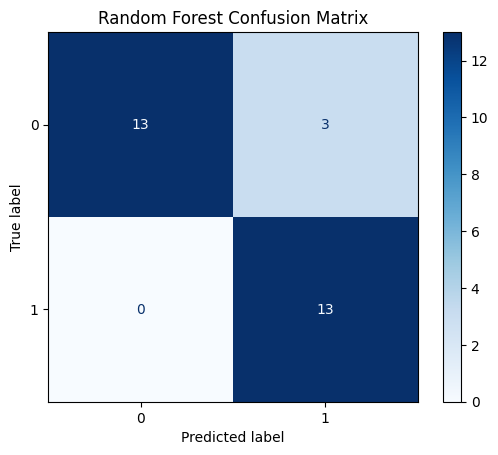

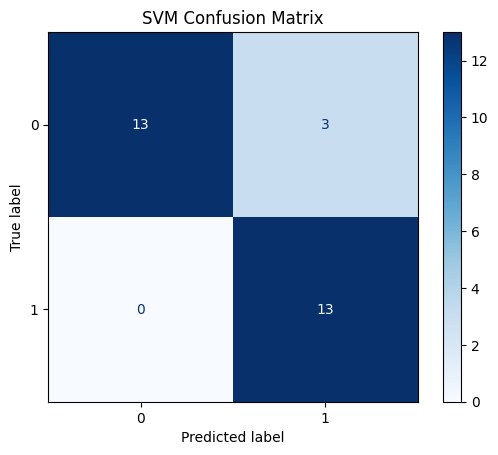

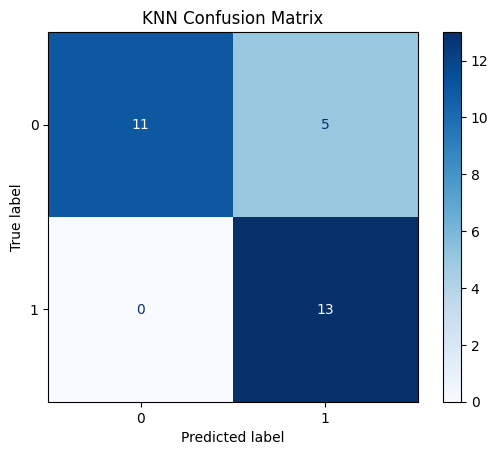

In [108]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

# ANALISIS

Pada percobaan pertama ini, citra daging diproses menggunakan tiga tahapan utama yaitu resize, grayscale, dan histogram equalization. Proses grayscale menghilangkan informasi warna sehingga struktur otot dan distribusi lemak menjadi lebih mudah diamati secara struktural. Pada citra daging segar, tampak jelas batas-batas antar jaringan otot dan lemak dengan distribusi intensitas kecerahan yang merata. Setelah dilakukan histogram equalization, kontras antara jaringan otot dan lemak menjadi lebih tinggi dan lebih menonjol. Sementara itu, pada citra daging busuk, struktur otot terlihat kabur dan tidak beraturan, serta terdapat area gelap dan terang yang tidak merata. Peningkatan kontras akibat histogram equalization justru memperjelas bercak-bercak yang mengindikasikan degradasi jaringan akibat proses pembusukan.

Hasil ekstraksi fitur tekstur dari citra menunjukkan adanya perbedaan mencolok antara daging segar dan busuk. Daging segar cenderung memiliki nilai contrast dan correlation yang tinggi, mencerminkan detail tekstur yang jelas dan teratur. Sebaliknya, pada daging busuk nilai homogeneity dan ASM lebih tinggi, menandakan pola tekstur yang lebih merata dan kurang detail akibat degradasi jaringan. Perbedaan-perbedaan ini menunjukkan bahwa fitur yang diekstraksi (seperti contrast, homogeneity, energy, dan correlation dari berbagai sudut) mampu merepresentasikan karakteristik penting dari masing-masing kelas citra.

Dari hasil pengujian menggunakan tiga model klasifikasi, yaitu Random Forest, SVM, dan KNN, diperoleh akurasi sebagai berikut: Random Forest dan SVM masing-masing mencapai akurasi sebesar 89,65%, sedangkan KNN memperoleh akurasi sebesar 82,75%. Hasil ini menunjukkan bahwa Random Forest dan SVM sama-sama efektif dalam memanfaatkan fitur tekstur dari preprocessing awal, sementara KNN menunjukkan performa yang sedikit lebih rendah. Perbedaan ini mengindikasikan bahwa pemilihan model berpengaruh pada hasil klasifikasi, terutama ketika fitur yang digunakan cukup kompleks seperti tekstur dari citra grayscale dengan equalisasi histogram.
